In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import utils.plotting_tools as plot

import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median

from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP, COBYLA
from qiskit.algorithms import VQE
from qiskit import Aer

import cirq

from qiskit.providers.aer import AerError

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'H'
atom_2 = 'H'
atom_3 = 'H'
basis = 'sto-3g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
coordinate_3 = (0.0, bond_len, 0.0)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2), (atom_3, coordinate_3)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham_f = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham_f)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
#print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (-0.017210915659800333+0j) [] +
(-0.036089282737986006+0j) [X0 X1 Y2 Y3] +
(-0.034934999375448306+0j) [X0 X1 Y4 Y5] +
(0.036089282737986006+0j) [X0 Y1 Y2 X3] +
(0.034934999375448306+0j) [X0 Y1 Y4 X5] +
(-0.026365874906949322+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.026365874906949322+0j) [X0 Z1 X2 Y3 Z4 Y5] +
(0.00922106569069939+0j) [X0 Z1 Z2 Z3 X4] +
(-0.023828207722769775+0j) [X0 Z1 Z2 Z3 X4 Z5] +
(0.014536731246500907+0j) [X0 Z1 Z2 X4] +
(-0.011829143660448417+0j) [X0 Z1 Z3 X4] +
(-0.011899632382875806+0j) [X0 Z2 Z3 X4] +
(0.036089282737986006+0j) [Y0 X1 X2 Y3] +
(0.034934999375448306+0j) [Y0 X1 X4 Y5] +
(-0.036089282737986006+0j) [Y0 Y1 X2 X3] +
(-0.034934999375448306+0j) [Y0 Y1 X4 X5] +
(-0.026365874906949322+0j) [Y0 Z1 Y2 X3 Z4 X5] +
(-0.026365874906949322+0j) [Y0 Z1 Y2 Y3 Z4 Y5] +
(0.00922106569069939+0j) [Y0 Z1 Z2 Z3 Y4] +
(-0.023828207722769775+0j) [Y0 Z1 Z2 Z3 Y4 Z5] +
(0.014536731246500907+0j) [Y0 Z1 Z2 Y4] +
(-0.011829143660448417+0j) [Y0 Z1 Z3 Y4] +
(-0.01189963238287

In [3]:
hamiltonian = qonvert.QubitOperator_to_dict(ham_q, num_qubits)#
terms_noncon = c_tools.greedy_dfs(hamiltonian, 1, criterion='weight')[-1]

In [4]:
order = [0,1,2,3,4,5]# [6, 7, 0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
circs = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, order, rot_A=True)
mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits, rot_G=True, rot_A=True)
A = mol.generators()[1]
#A_sim=[]
#ucc_terms={}
#for i in ucc.keys():
#    ucc_terms[i] = ucc[i]
#    A_sim.append(circs.CS_VQE(ucc_terms, 8, A)[0])

#fig, ax = plt.subplots(1, 1)
#ax.plot(list(range(len(A_sim))), A_sim)
#ax.set_ylim(0,1.1)
#ax.get_yaxis().get_major_formatter().set_useOffset(False)
#print('Expectation Value of A:', circs.CS_VQE(['IIIIYYYY', 'YYYYIIII', 'IXIXIXIX'], 8, A)[0])

#mol.init_state()

In [13]:
cs_vqe_results = circs.run_cs_vqe(ucc, max_sim_q = 3, iters=5)

*Performing CS-VQE over the following qubit positions: (5,)
*Performing CS-VQE over the following qubit positions: (5,)


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


*Performing CS-VQE over the following qubit positions: (5,)
*Performing CS-VQE over the following qubit positions: (5,)
*Performing CS-VQE over the following qubit positions: (5,)
*Performing CS-VQE over the following qubit positions: (5, 4)
*Performing CS-VQE over the following qubit positions: (5, 4)
*Performing CS-VQE over the following qubit positions: (5, 4)
*Performing CS-VQE over the following qubit positions: (5, 4)
*Performing CS-VQE over the following qubit positions: (5, 4)
*Performing CS-VQE over the following qubit positions: (5, 4, 3)
*Performing CS-VQE over the following qubit positions: (5, 4, 3)
*Performing CS-VQE over the following qubit positions: (5, 4, 3)
*Performing CS-VQE over the following qubit positions: (5, 4, 3)
*Performing CS-VQE over the following qubit positions: (5, 4, 3)


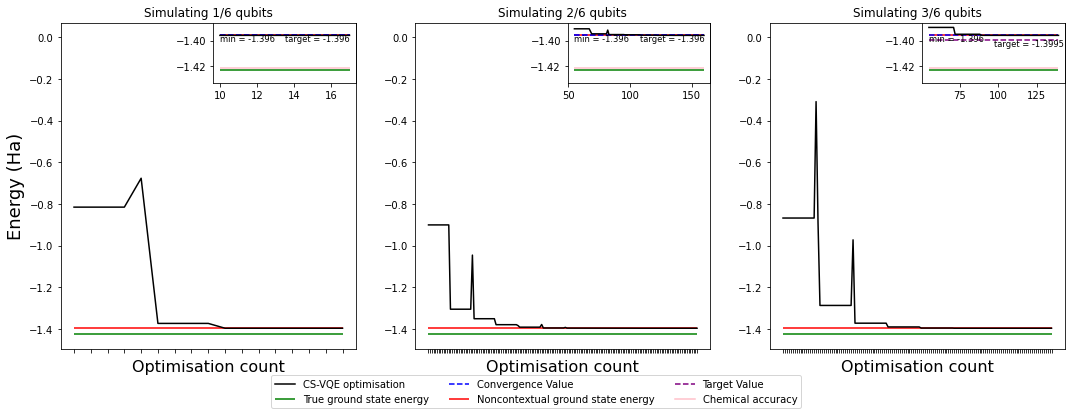

In [14]:
fig = plot.plot_cs_vqe_convergence(data=cs_vqe_results)

In [7]:
#fig.savefig("plots/HeH+-CS-VQE-uccsd_ansatz.png", dpi=300)

In [8]:
#data={}
#for k in cs_vqe_results.keys():
#    data[str(k)] = cs_vqe_results[k]
#        
#json.dumps(data)

In [9]:
#import json 
#     
#with open("data/HeH+_3-21G_UCCSD_CS_VQE_results.json", "w") as outfile: 
#    json.dump(data, outfile)

In [10]:
#circs.build_circuit(['IXIXIXIX'], 8).draw()

In [11]:
#cs_vqe_plot = plot.plot_cs_vqe_convergence(hamiltonian, terms_noncon, ucc, num_qubits, order, 4, rot_A=True)

In [12]:
from qiskit.quantum_info.operators import Operator, Pauli
# Create an operator
P1 = Operator(Pauli(label='IZZZZZXI'))
P2 = Operator(Pauli(label='IIIIIIZI'))

# Add to a circuit
circ = QuantumCircuit(8)
circ.append(0.618*P1+0.618*P2,[0,1,2,3,4,5,6,7])
circ.draw()

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/quantum_info/operators/symplectic/pauli.py:187: DeprecationWarning: Initializing Pauli from `Pauli(label=l)` kwarg is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. Use `Pauli(l)` instead.
  base_z, base_x, base_phase = self._from_label_deprecated(label)


ExtensionError: 'Input matrix is not unitary.'

In [ ]:
print(eig.eigenstate(A, 16, num_qubits).construct())
print(eig.eigenstate(A, 18, num_qubits).construct())

In [ ]:
I_op = openfermion.ops.QubitOperator.identity()
A_op = qonvert.dict_to_QubitOperator(A)
A_array = get_sparse_operator(A_op, n_qubits=8).toarray()

In [ ]:
psi = la.random_complex_vector(2**8)
projector = get_sparse_operator((A_op+I_op)/2, n_qubits=8).toarray()

In [ ]:
psi_sub = np.dot(projector, psi)
psi_conj = np.conjugate(psi_sub)
norm = np.sqrt(np.dot(psi_conj, psi_sub))

In [ ]:
psi_sub = psi_sub/norm
psi_conj = np.conjugate(psi_sub)
np.dot(psi_conj, psi_sub)

In [ ]:
la.expectation(A_op, psi_sub, 8)

In [ ]:
conj_psi = np.conjugate(psi)
conj_psi.dot(psi)

In [ ]:
type(projector)

In [ ]:
qc=QuantumCircuit(2,1)
qc.h(0), qc.h(1)
qc.cx(1,0)
qc.reset(1)
qc.measure_all()
qc.draw()


# execute the quantum circuit
backend = BasicAer.get_backend('qasm_simulator') # the device to run on
result = execute(qc, backend, shots=1000).result()
counts  = result.get_counts(qc)
print(counts)
plot_histogram(counts)

In [ ]:
test_list=[(0, 2, 4), (5, 2, 3), (3, 1, 8)]

In [ ]:
sorted([i for i in test_list], key=lambda i:i[0])

In [ ]:
circs.qubit_map(7)

In [ ]:
circs.reference_state()